<a href="https://colab.research.google.com/github/SabyasachiBanik/repo1/blob/main/Practical1_FoDS_SBanik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 1 : Implementation of Linear Regression (Ridge, Lasso)

This practical has two parts. The first part is to implement and train a linear regression model using the least squares method. We will implement the model and train it on the winequality dataset using the NumPy library. Learning curves will be plotted to determine if the model is overfitting or underfitting.

In the second part, we will apply the basis expansion to the dataset and train linear regression models with regularization, i.e., Ridge and Lasso. These tasks do not need to be implemented from scratch -- We will use the functions from the scikit-learn library. During training, we use the validation data to determine the optimal hyperparameters. 
An optional task is to implement the hyperparameter selection using the k-fold cross-validation method. Five bonus points are awarded for this task. 



We will use the following packages:

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cp

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/Colab Notebooks"

 example.ipynb			      Untitled0.ipynb
 Practical1_FoDS_Banik.ipynb	      Untitled1.ipynb
 Practical1_HS22_skeleton.ipynb       winequality-white.pickle
'Practical 1_Tasks_Explanation.mp4'


## Dataset
We will use the winequality dataset for this practical. The dataset is available here:
https://archive.ics.uci.edu/ml/datasets/Wine+Quality. 
In order to make it easier to import the dataset, the dataset has been converted to the numpy array format and shuffled, so that we can start the practical directly. The converted dataset is available on the OLAT page.

#### Attribute Information
Input variables (based on physicochemical tests):
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):

12. quality (score between 0 and 10)



There are two files in the dataset, one for white wine data and one for red wine data. We focus on the white wine data, which is the larger dataset. The following code loads the data:

In [9]:
# load the white wine dataset
# X is the feature matrix that stores the feature values of the data records
# y is the label vector that stores the labels of the data records
X, y = cp.load(open("/content/drive/My Drive/Colab Notebooks/winequality-white.pickle", 'rb'))

# check the size of the data
print("X is a matrix with the dimension {}. That is, {} data records and {} features.".format(X.shape, X.shape[0], X.shape[1]))
print("y is a vector with {} values. They are the labels of the data records in X.".format(y.shape[0]))


X is a matrix with the dimension (4898, 11). That is, 4898 data records and 11 features.
y is a vector with 4898 values. They are the labels of the data records in X.


## Understanding What We’re Predicting

First, let's look at the labels. 
We make the bar chart below to show the distribution of labels in the dataset. 
The y-values are integers from 3 to 9. 


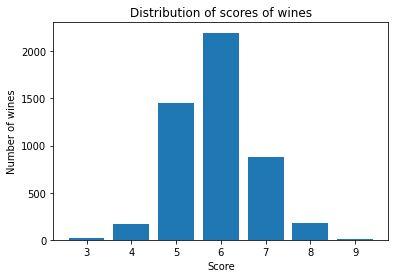

In [10]:
# the function takes the y-values in the training data as the input and makes the bar chart. 
def plot_bar_chart_score(y):
    fix, ax = plt.subplots()
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel('Score')
    plt.ylabel('Number of wines')
    plt.title('Distribution of scores of wines')
    plt.show()

plot_bar_chart_score(y)

Our goal is to train a model that can take wine records in X and predict the quality of the wines.
We split the data into training data and test data. 
In practice, we should sample randomly 80% of the data as training data and the rest as the test data. 
Though, in this practical, let's all use the same split: the **first** 80% of the data for training and the remaining 20% for testing. This makes sure we can compare your results to ours.

### **Task 1** 
The first task is to write a function that can split the dataset into training and testing data according to the parameter `split_coeff`. When `split_coeff` is set to 0.8, it means the function sets the first 80% of the data as the training data and the remaining 20% as the testing data. 

In [6]:
# The function splits the dataset into training data and testing data.
# The parameter split_coeff is a percentage value such that
# the first split_coeff of the dataset become the training data
# and the remaining data become the test data
def split_data(X, y, split_coeff=0.8):
    # The code below is just for compilation. 
    # You need to delete it and write your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    split_idx= int(split_coeff * X.shape[0])
    X_train = X[:split_idx, :]
    y_train = y[:split_idx]
    X_test = X[split_idx:, :]
    y_test = y[split_idx:]

    '''
    #Alternative Option
    X_train, X_test = np.split(X,[int(split_coeff * X.shape[0])])
    y_train, y_test = np.split(y,[int(split_coeff * y.shape[0])])
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################
    '''
    return X_train, y_train, X_test, y_test


Your function should return the expected output as shown in the code block below. 

In [11]:
X_train, y_train, X_test, y_test = split_data(X, y, 0.8) # split the data with split_coeff=0.8

# check the size of the splitted dataset
print("Shape of X_train:", X_train.shape) # expected output (3918, 11)
print("Shape of y_train:", y_train.shape) # expected output (3918,)
print("Shape of X_test:", X_test.shape) # expected output (980, 11)
print("Shape of y_test:", y_test.shape) # expected output (980,)

Shape of X_train: (3918, 11)
Shape of y_train: (3918,)
Shape of X_test: (980, 11)
Shape of y_test: (980,)


### **Task 2** 

As a first step, we construct a trivial model that returns the mean of the y-values in the training data for any wine record in X. We use this trivial model as a baseline. The linear regression models we build later should perform better than this trivial model.

In [12]:
#@title
# Task 2: implement the trivial predictor
# The function computes the average value of y on the training label values
def compute_average(y_train):
    # The code below is just for compilation. 
    # You need to delete it and write your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    # Hint: return the mean of y_train
    return np.mean(y_train)
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################
    
y_train_avg = compute_average(y_train)
print("The average of the y-values in the training data is {}".format(y_train_avg)) 

# The trivial predictor returns the average value.
def trivial_predictor(X_test, y_train_avg):
  return y_train_avg


The average of the y-values in the training data is 5.878764675855028


### **Task 3**
We next evaluate the trivial predictor on the training data and test data. 
We use mean squared error (MSE) to measure the performance of the predictor.
The task is to implement a function that reports the mean squared error of the given predictor on the given data. 

In [13]:
# We next test our trivial predictor on the training data and test data. 
# Implement a function that can report the mean squared error 
# of a predictor on the given data
# Input: data and predictor
# Output: mean squared error of the predictor on the given data
def test_predictor(X, y, predictor: callable=None):
    # Apply the predictor to each row of the matrix X to get the predictions
    y_predicted = np.apply_along_axis(predictor, 1, X)

    # TODO: compute the mean squared error of y
    # The code below is just for compilation. 
    # You need to delete it and write your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    mse = np.mean((y-y_predicted)**2)
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################
    
    return mse

# use the function test_predictor to test the trivial predictor
# we use the lambda function here to pass the function trivial predictor to the function test_predictor.
mse_trivial_predictor_train = test_predictor(X_train, y_train, lambda x: trivial_predictor(x, y_train_avg))
mse_trivial_predictor_test = test_predictor(X_test, y_test, lambda x: trivial_predictor(x, y_train_avg))

# Report the result
print('Trivial Predictor')
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_trivial_predictor_train)
print('MSE (Testing)  = %.4f' % mse_trivial_predictor_test)

Trivial Predictor
--------------------------------------------------------------------------------

MSE (Training) = 0.7768
MSE (Testing)  = 0.8139


## Train the Linear Model Using the Least Squares Method

Let's next train a linear regression model on the training data. 
We use the closed form solution of the least squares estimate to compute the parameters of the linear regression model. 
This model should perform better than the trivial predictor.

### **Task 4**
Before training the model, we need to standardize the data, i.e., transform the data so that every feature has mean 0 and variance 1. 

https://en.wikipedia.org/wiki/Standard_score

We first standardize the training data, and then apply the same transformation to the test data. That is, standardize the test data using the means and the standard deviations of the training data. 

In [14]:
# The task is to implement a function that can standardize the data and returns the mean and std of the data.
# Input: training data
# Output: standardize training data, standard deviations and means
def standardize_data(X):
    # TODO: compute the means and standard deviations of the data, and standardize the data
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_std = (X-mean)/std
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################
    
    return X_std, mean, std

# Standardize the training data and store the means and the stds 
X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)
print("X_train_std:", X_train_std.shape)
print("Mean:", X_train_mean)
print("Standard deviation:", X_train_std_div)

X_train_std: (3918, 11)
Mean: [6.85427514e+00 2.78390761e-01 3.34892802e-01 6.42623788e+00
 4.58213374e-02 3.53263144e+01 1.38513272e+02 9.94040729e-01
 3.18647524e+00 4.89055641e-01 1.05115799e+01]
Standard deviation: [8.39100902e-01 9.95630176e-02 1.24249975e-01 5.06377532e+00
 2.16660282e-02 1.71004677e+01 4.23956179e+01 2.97972269e-03
 1.49949475e-01 1.12992053e-01 1.22536544e+00]


In [15]:
np.std(X_train_std, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [16]:
# TODO: Standardize the test data using the means and standrad deviations of the training data
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
X_test_std = (X_test-X_train_mean)/X_train_std_div
print(X_test_std.shape)
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

(980, 11)


### **Task 5**
Let's now train the linear model using the least-squares method. 
We need to add the bias term to the matrix X. 

In [18]:
# The task is to implement the function that adds a column of ones to the first column of X
def expand_with_ones(X):
    # TODO: add a column of ones to the front of the input matrix
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    X_out = np.c_[np.ones(X.shape[0]), X]
    return X_out
    
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

# Train the linear model using the least-squares method
# The task is to implement the function that computes the parameters
def least_squares_compute_parameters(X_input, y):
    # add the bias column to the data
    X = expand_with_ones(X_input)

    # TODO: compute the parameters based on the expanded X and y using the least-squares method
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    w= np.linalg.lstsq(X, y, rcond=None)[0]
    return w
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

# Apply the function to train the linear model
w = least_squares_compute_parameters(X_train_std, y_train) 
print("w:", w.shape)

w: (12,)


After computing the parameters,
we can build the linear model predictor.
The predictor takes as input the computed parameters and the data, and predicts the labels for the input data.

In [19]:
# Implement the linear model predictor
# Input: test data and parameters
# Output: predicted values
def linear_model_predictor(X, w):
    # TODO: predict the labels for the input data
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################

    return X@w
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################


Evaluate our linear regression model predictor on the test data. 

In [20]:
# use the function test_predictor to evaluate the linear model predictor
mse_linear_model_predictor = test_predictor(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))
print("Mean squared error is {}".format(mse_linear_model_predictor))

Mean squared error is 0.5607292042283477


## Learning Curves

Let us check if the linear model is overfitting or underfitting. Since the dataset is somewhat large and there are only 11 features, the model shouldn't be overfitting. 
To check it, we use the learning curves: we plot how the performance of the model changes when it is trained with increasingly more data. 

### **Task 6** 

Let's first implement a function that comprises what we have implemented above. 
The function takes as inputs the data and the split coefficient, and then
1. standardizes the data,
2. trains the linear model (compute the parameters), and
3. reports the MSE of the linear model predictor on both the training and the test data. 

In [22]:
# Input: training data and test data
# Output: mse of the linear model predictor on both the training and test data
def train_and_test(X_train, y_train, X_test, y_test):
    # TODO: implement the function 
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    # Hints: use the functions you have implemented
    
    #1
    X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)
    X_test_std = (X_test-X_train_mean)/X_train_std_div

    #2
    w = least_squares_compute_parameters(X_train_std, y_train)

    #3
    mse_train = test_predictor(expand_with_ones(X_train_std), y_train, lambda x: linear_model_predictor(x, w))
    mse_test = test_predictor(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))
    
    return mse_train, mse_test
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

mse_train, mse_test = train_and_test(X_train, y_train, X_test, y_test)
print('Linear Model')
print('-----------------------\n')
print('MSE (Training) = %.4f' % mse_train)
print('MSE (Testing)  = %.4f' % mse_test)


Linear Model
-----------------------

MSE (Training) = 0.5640
MSE (Testing)  = 0.5607


### **Task 7**

We are now ready to plot the learning curves. 

We train a list of models on the increasingly more training data ([20, 40, ..., 600] data records).
For each of such model, we compute the MSEs of the model on both the training data and the test data, and store the MSEs in the lists `mse_train_v` and `mse_test`, respectively. 
The code provided below will then plot the learning curves.

Your plot should show the two curves (roughly) meet at round 150 training data records.

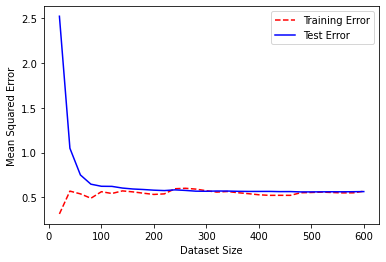

In [23]:
mse_train_v = []
mse_test_v = []

TRAINING_SIZE_MAX = 601
TRAINING_SIZE_MIN = 20

# compute the MSE over data with sizes from TRAINING_SIZE_MIN to TRAINING_SIZE_MAX with increasing step 20
for train_size in range(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20):
    # TODO: 
    #   1. use the first train_size data records from the X_train and y_train as the training data
    #   2. train and compute the MSE on both training and test data using the train_and_test function
    #   3. add the computed MSE to the lists mse_train_v and mse_test_v
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    mse_train, mse_test = train_and_test(X_train[:train_size,:], y_train[:train_size], X_test, y_test)
    
    
    mse_train_v.append(mse_train)
    mse_test_v.append(mse_test)
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################
    

# The below code generates the learning curves plot
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_train_v, 'r--', label="Training Error")
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_test_v, 'b-', label="Test Error")
plt.legend(loc="upper right")
plt.xlabel('Dataset Size')
plt.ylabel('Mean Squared Error')
plt.show()

## Polynomial Basis Expansion and Regularisation

In this part, we will improve the linear regression model by basis expansion and regularization: 
1. apply the degree 2 basis expansion to the data, 
2. build the Ridge and Lasso models and
3. perform hyperparameter optimization using the validation data. 

For the hyperparameter optimization, you should set the last 20% of the training data for the purpose of validation and try lambda values in the range [10^-4, 10^-3, 10^-2, 10^-1, 1, 10, 100]. 

We will use the scikit-learn library. We have imported the necessary functions for you. You can import other scikit-learn functions if you think they are useful. The documentation is available here: http://scikit-learn.org/stable/modules/classes.html

In [24]:
# import the preprocessing libs for standarization and basis expansion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 

# Ridge and Lasso linear model
from sklearn.linear_model import Ridge, Lasso 

### **Task 8**
Let's implement the function for expanding the basis of the dataset. 

Hints: use `PolynomialFeatures`

In [25]:
def expand_basis(X, degree):
    # TODO: expand the basis of X for the input degree
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    # Hints: use the function PolynomialFeatures
    
    poly = PolynomialFeatures(degree)
    return poly.fit_transform(X)

    
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

### **Task 9**
We need to prepare the data.
We first expand and standardize the data,
and then split the training data to training data and validation data.
We use the last 20% of the training data as the validation data.

Hints: use `StandardScaler` and `std_scaler` to standardize the data

In [27]:
def prepare_data(X, y, degree):
    # TODO: the training, test and validation data using the expanded dataset.
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    # Hints: follow the steps     
    # 1. split the data (X, y) into training data (X_train, y_train) and test data (X_test, y_test)
    # 2. standardize the training data and do the same transformation to the test data
    # 3. expand the basis of the training data and test data
    # 4. split the expanded training data into training data (X_train_n, y_train_n) and validation data (X_train_v, y_train_v)
    
    # training data
    #X_train = X
    #y_train = y

    # test data
    #X_test = X 
    #y_test = y


    # 1
    X_train, y_train, X_test, y_test = split_data(X, y, 0.8)  # used already implemented function
    
    # 2 Used StandardScaler and std_scaler to standardize the data
    scaler = StandardScaler()
    scaler.fit(X_train) # fit on X_train
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # 2 Alternate Option
    '''
    X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)
    X_test_std = (X_test-X_train_mean)/X_train_std_div
    '''

    # 3
    X_train = expand_basis(X_train_std, degree)
    X_test = expand_basis(X_test_std, degree)


    # further split the training data to training and validation data
    # training data
    #X_train_n = X 
    #y_train_n = y

    # validation data
    #X_train_v = X 
    #y_train_v = y

    # 4
    X_train_n, y_train_n, X_train_v, y_train_v = split_data(X_train, y_train, 0.8)
    

    return X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, 2) # here we expand the dataset with degree 2

# check the size of the splitted dataset
print("Shape of X_train_n:", X_train_n.shape) # expected output (3134, 78)
print("Shape of y_train_n:", y_train_n.shape) # expected output (3134,)
print("Shape of X_train_v:", X_train_v.shape) # expected output (784, 78)
print("Shape of y_train_v:", y_train_v.shape) # expected output (784,)
print("Shape of X_test:", X_test.shape) # expected output (980, 78)
print("Shape of y_test:", y_test.shape) # expected output (980,)

Shape of X_train_n: (3134, 78)
Shape of y_train_n: (3134,)
Shape of X_train_v: (784, 78)
Shape of y_train_v: (784,)
Shape of X_test: (980, 78)
Shape of y_test: (980,)


### **Task 10**
We have prepared the training data and the validation data. 
We can now use the validation data to select the optimal hyperparameters for the Ridge and Lasso models. 
We use the Ridge and Lasso models from scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

We train Ridge or Lasso models with different lambda values and check their performance on the validation data, and select the lambda values that yield the best performance. 

In [33]:
from sklearn.metrics import mean_squared_error # method 2

In [31]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Ridge lambda: 10
Lasso lambda: 0.001


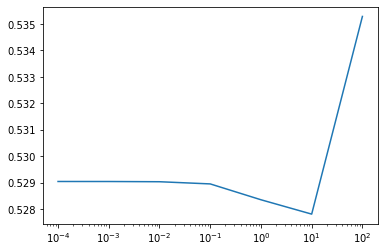

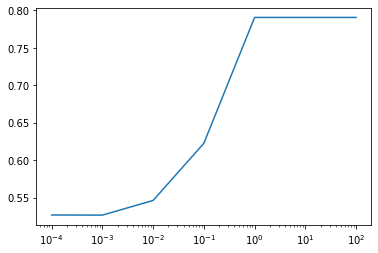

In [34]:
# The function takes the training and validation data as inputs, and 
# returns the lambda value that results the minimal mse
# We use is_ridge to indicate which the model is considered.
# is_ridge = True indicates Ridge while is_ridge = False indicates Lasso
def choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, is_ridge: bool):
    mse_arr = []
    lam_arr = []

    # Try lambda values from 10^-4 to 10^2. 
    # Record the mse and the lambda values in mse_arr and lam_arr
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    for pow_lam in range(-4, 3):
        lam = 10 ** pow_lam

        clf = Ridge(alpha = lam) if is_ridge else Lasso(alpha = lam)
        clf.fit(X_train_n, y_train_n)
        #mse = test_predictor(X_train_v, y_train_v, lambda x: clf.predict(X_train_v))  # method 1
        mse = mean_squared_error(y_train_v, clf.predict(X_train_v))  # method 2

        mse_arr.append(mse) 
        lam_arr.append(lam) 

    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################


    # get the index of the lambda value that has the minimal use
    lambda_idx_min = np.argmin(np.array(mse_arr))

    # plot of the lambda values and their mse
    plt.figure()
    plt.semilogx(lam_arr, mse_arr)

    # return the optimal lambda value
    return lam_arr[lambda_idx_min]
    

# call the function to choose the lambda for Ridge and Lasso
lam_ridge = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, True)
lam_lasso = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, False)

print("Ridge lambda:", lam_ridge)
print("Lasso lambda:", lam_lasso)

### **Task 11**:
Once we get the optimal lambdas for Ridge and Lasso, we train these models using these lambdas on the full training data, and then report their performance.

In [35]:
# TODO: train the Ridge and Lasso models using the optimal parameters, and
#       report their MSE
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
# Hints: train these models on the full training data
clf = Ridge(alpha=lam_ridge)
clf.fit(X_train, y_train)

#mse_ridge_train = test_predictor(X_train, y_train, lambda x: clf.predict(X_train))  # method 1
#mse_ridge_test = test_predictor(X_test, y_test, lambda x: clf.predict(X_test))  # method 1
mse_ridge_train = mean_squared_error(y_train, clf.predict(X_train))  # method 2
mse_ridge_test = mean_squared_error(y_test, clf.predict(X_test))  # method 2

#mse_ridge_train = 0
#mse_ridge_test = 0


clf = Lasso(alpha=lam_lasso)
clf.fit(X_train, y_train)

#mse_lasso_train = test_predictor(X_train, y_train, lambda x: clf.predict(X_train))  # method 1
#mse_lasso_test = test_predictor(X_test, y_test, lambda x: clf.predict(X_test))  # method 1
mse_lasso_train = mean_squared_error(y_train, clf.predict(X_train))  # method 2
mse_lasso_test = mean_squared_error(y_test, clf.predict(X_test))  # method 2

#mse_lasso_train = 0
#mse_lasso_test = 0
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

# Report the result
print('For Ridge Regression with using degree %d polynomial expansion and lambda = %.4f' % (2, lam_ridge))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso with using degree %d polynomial expansion and lambda = %.4f' % (2, lam_lasso))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)

For Ridge Regression with using degree 2 polynomial expansion and lambda = 10.0000
--------------------------------------------------------------------------------

MSE (Training) = 0.4955
MSE (Testing)  = 0.5117


For Lasso with using degree 2 polynomial expansion and lambda = 0.0010
---------------------------------------------------------------------

MSE (Training) = 0.4962
MSE (Testing)  = 0.5098


## Optional: Try Larger Degrees using K-fold Cross Validation



### **Task 12**
This is an optional task, which worths 5 bonus points.

The task is to try basis expansions with higher degrees (up to degree 4) and find the degree that results the best performance. 
Instead of always using the same validation data, we use k-fold cross-validation to find the optimal hyperparameters. 

Your task is to report the optimal hyperparameters (the basis expansion degree and the lambdas) and the MSEs of the Ridge and Lasso when using these optimal hyperparameters. 

Hints: Use `KFold` to do this automatically. 

In [36]:
# KFold
from sklearn.model_selection import KFold

###################################################
##### YOUR CODE STARTS HERE #######################
###################################################


###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

In [37]:
def prepare_data_kfold(X, y, degree):
    # 1.
    X_train, y_train, X_test, y_test = split_data(X, y, 0.8) # use already implemented function
    
    # 2.
    scaler = StandardScaler()
    scaler.fit(X_train) # fit on X_train
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test) # use the same transformation
    
    # 3.
    X_train = expand_basis(X_train, degree)
    X_test = expand_basis(X_test, degree)

    return X_train, y_train, X_test, y_test

In [38]:
def choose_hyper_param(X_train, y_train, is_ridge: bool):
    mse_arr = []
    lam_arr = []

    for pow_lam in range(-4, 3):
        lam = 10 ** pow_lam
        
        clf = Ridge(alpha=lam) if is_ridge else Lasso(alpha=lam)
        
        cv = KFold(n_splits=10, random_state=None, shuffle=False)
        
        #mse = np.mean(cross_val_score(clf, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
        
        mses = []
        for train_index, valid_index in cv.split(X_train):
            clf.fit(X_train[train_index], y_train[train_index])
            mse = mean_squared_error(y_train[valid_index], clf.predict(X_train[valid_index]))
            mses.append(mse)
        mse = sum(mses) / len(mses)
        
        mse_arr.append(mse) 
        lam_arr.append(lam)


    # get the index of the lambda value that has the minimal use
    lambda_idx_min = np.argmin(np.array(mse_arr))

    # plot of the lambda values and their mse
    plt.figure()
    plt.semilogx(lam_arr, mse_arr)

    # return the optimal lambda value
    return lam_arr[lambda_idx_min]

In [39]:
#from sklearn.metrics import get_scorer_names
#get_scorer_names()

Degree: 1:
Shape of X_train: (3918, 12)
Shape of y_train: (3918,)
Shape of X_test: (980, 12)
Shape of y_test: (980,)
Ridge lambda: 100
Lasso lambda: 0.001
For Ridge Regression with using degree 1 polynomial expansion and lambda = 100.0000
MSE (Training) = 0.5657
MSE (Testing)  = 0.5627
For Lasso with using degree 1 polynomial expansion and lambda = 0.0010
MSE (Training) = 0.5641
MSE (Testing)  = 0.5610
---------------------------------------------------------------------

Degree: 2:
Shape of X_train: (3918, 78)
Shape of y_train: (3918,)
Shape of X_test: (980, 78)
Shape of y_test: (980,)
Ridge lambda: 10
Lasso lambda: 0.001
For Ridge Regression with using degree 2 polynomial expansion and lambda = 10.0000
MSE (Training) = 0.4955
MSE (Testing)  = 0.5117
For Lasso with using degree 2 polynomial expansion and lambda = 0.0010
MSE (Training) = 0.4962
MSE (Testing)  = 0.5098
---------------------------------------------------------------------

Degree: 3:
Shape of X_train: (3918, 364)
Shape o

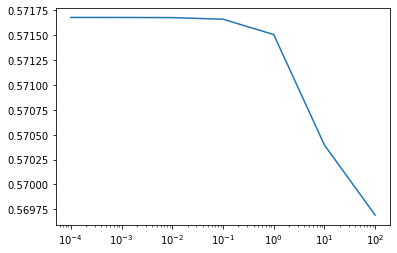

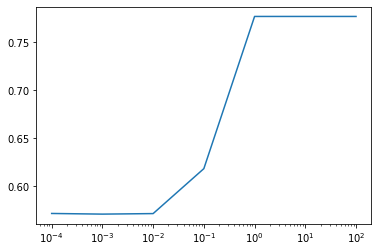

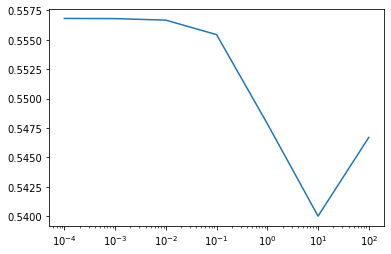

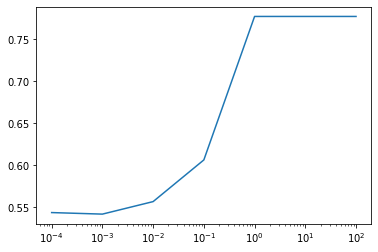

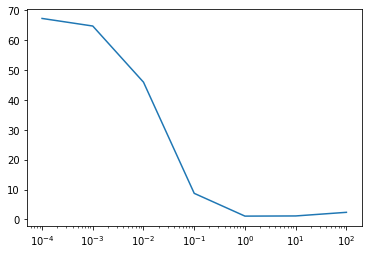

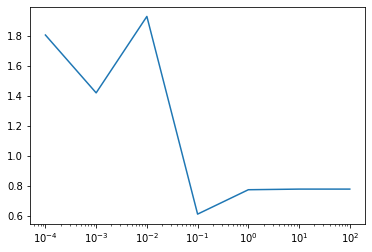

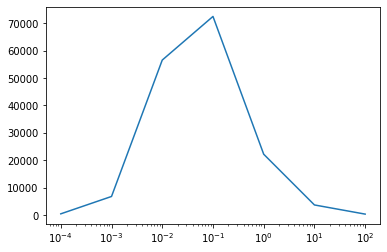

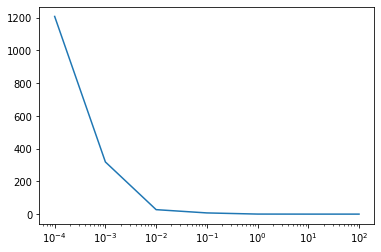

In [40]:
for degree in range (1, 4 + 1):
    
    # 1. Prepare data
    X_train, y_train, X_test, y_test = prepare_data_kfold(X, y, degree)
    # check the size of the splitted dataset
    print('Degree: {}:'.format(degree))
    print("Shape of X_train:", X_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_test:", y_test.shape)
    
    
    # 2.
    # call the function to choose the lambda for Ridge and Lasso
    lam_ridge = choose_hyper_param(X_train, y_train, True)
    lam_lasso = choose_hyper_param(X_train, y_train, False)
    print("Ridge lambda:", lam_ridge)
    print("Lasso lambda:", lam_lasso)
    
    
    # 3.
    clf = Ridge(alpha=lam_ridge)
    clf.fit(X_train, y_train)

    mse_ridge_train = mean_squared_error(y_train, clf.predict(X_train))  # method 2
    mse_ridge_test = mean_squared_error(y_test, clf.predict(X_test))  # method 2

    clf = Lasso(alpha=lam_lasso)
    clf.fit(X_train, y_train)

    mse_lasso_train = mean_squared_error(y_train, clf.predict(X_train))  # method 2
    mse_lasso_test = mean_squared_error(y_test, clf.predict(X_test))  # method 2

    # Report the result
    print('For Ridge Regression with using degree %d polynomial expansion and lambda = %.4f' % (degree, lam_ridge))
    print('MSE (Training) = %.4f' % mse_ridge_train)
    print('MSE (Testing)  = %.4f' % mse_ridge_test)

    print('For Lasso with using degree %d polynomial expansion and lambda = %.4f' % (degree, lam_lasso))
    print('MSE (Training) = %.4f' % mse_lasso_train)
    print('MSE (Testing)  = %.4f' % mse_lasso_test)
    print('---------------------------------------------------------------------\n')